In [1]:
!pwd

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import os, pandas as pd

DATA_DIR = "./KuaiRec 2.0/data/"   # <- the CSVs are here

print("Top-level in KuaiRec 2.0:", os.listdir("./KuaiRec 2.0"))
print("Inside data/:", os.listdir(DATA_DIR))

def peek(csv):
    df = pd.read_csv(os.path.join(DATA_DIR, csv), nrows=5)
    print(f"\n=== {csv} ===")
    print(list(df.columns))
    print(df.head(), "\n")
    return df

_ = peek("small_matrix.csv")
_ = peek("user_features.csv")
_ = peek("item_daily_features.csv")

/Users/ooooo/materials-f25/materials-f25
Top-level in KuaiRec 2.0: ['.DS_Store', 'LICENSE', 'figs', 'loaddata.py', 'Statistics_KuaiRec.ipynb', 'data']
Inside data/: ['kuairec_caption_category.csv', 'item_daily_features.csv', 'item_categories.csv', 'user_features.csv', 'small_matrix.csv', 'social_network.csv', 'big_matrix.csv']

=== small_matrix.csv ===
['user_id', 'video_id', 'play_duration', 'video_duration', 'time', 'date', 'timestamp', 'watch_ratio']
   user_id  video_id  play_duration  video_duration                     time  \
0       14       148           4381            6067  2020-07-05 05:27:48.378   
1       14       183          11635            6100  2020-07-05 05:28:00.057   
2       14      3649          22422           10867  2020-07-05 05:29:09.479   
3       14      5262           4479            7908  2020-07-05 05:30:43.285   
4       14      8234           4602           11000  2020-07-05 05:35:43.459   

         date     timestamp  watch_ratio  
0  20200705.0  1.5

Alpha = 0.01, Testing loss = 0.08472680324360729
Alpha = 0.1, Testing loss = 0.08472680180698668
Alpha = 1, Testing loss = 0.0847267874564924
Alpha = 10, Testing loss = 0.08472664551631945
Best alpha: 10
Training loss: 0.09596162245973475
Testing loss: 0.08472664551631945


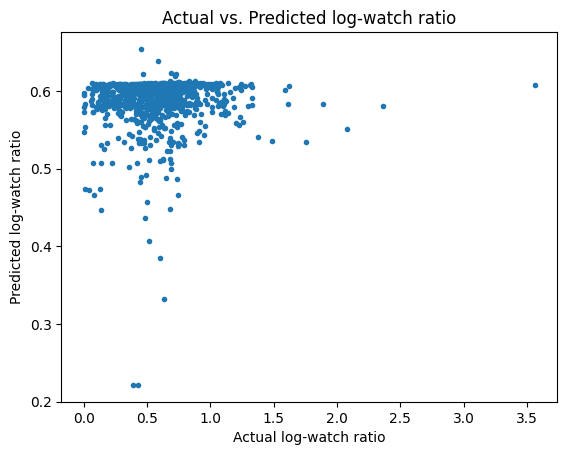

In [9]:
'''
Assignment 08-23: watch prediction
'''
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

DATA_DIR = "./KuaiRec 2.0/data/"

def get_kuairec_data(data_dir=DATA_DIR):
	# adapted from https://github.com/chongminggao/KuaiRec/blob/main/loaddata.py
    csv_dir = data_dir

    try:
        # big_matrix = pd.read_csv(os.path.join(csv_dir,"big_matrix.csv"))
        small_matrix = pd.read_csv(os.path.join(csv_dir,"small_matrix.csv"))
        # social_network = pd.read_csv(os.path.join(csv_dir,"social_network.csv"))
        # social_network["friend_list"] = social_network["friend_list"].map(eval)
        # item_categories = pd.read_csv(os.path.join(csv_dir,"item_categories.csv"))
        # item_categories["feat"] = item_categories["feat"].map(eval)
        user_features = pd.read_csv(os.path.join(csv_dir,"user_features.csv"))
        item_daily_feat = pd.read_csv(os.path.join(csv_dir,"item_daily_features.csv"))
    except FileNotFoundError as e:
        print("Data file not found at", csv_dir)
        print("Have you downloaded the data? See https://kuairec.com/#download-the-data")
    return small_matrix, item_daily_feat, user_features

def extract_features_labels(small_matrix, item_daily_feat, user_features):
	# Joining user and item features
	merged_user_matrix = small_matrix.merge(user_features, how='left', on='user_id')
	merged_matrix = merged_user_matrix.merge(item_daily_feat, how='left', on=['video_id', 'date'])

	# Cleaning and subsampling
	merged_matrix.dropna(inplace=True)
	subsampled_matrix = merged_matrix.sample(n=10000, random_state=0)
	label_name = ['watch_ratio']  # target
	features_name = ['like_cnt', 'comment_cnt', 'music_id', # about video
	                                'follow_user_num_x', 'friend_user_num'] # about user
	data_matrix = subsampled_matrix[label_name + features_name]

	return label_name, features_name, data_matrix                             


# Loading data
small_matrix, item_daily_feat, user_features = get_kuairec_data()
# Merging and extracting features and lavels
label_name, features_name, data_matrix = extract_features_labels(small_matrix, item_daily_feat, user_features)


# Keep the original splitting logic
y_train = np.log(1 + np.array(data_matrix[:9000][label_name]))
X_train = np.array(data_matrix[:9000][features_name])

y_eval = np.log(1 + np.array(data_matrix[9000:][label_name]))
X_eval = np.array(data_matrix[9000:][features_name])

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

# Hyperparameter tuning
best_loss = float('inf')
best_alpha = None
for alpha in [0.01, 0.1, 1, 10]:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred_eval = model.predict(X_eval_scaled)
    loss = np.mean((y_pred_eval - y_eval)**2)
    print(f'Alpha = {alpha}, Testing loss = {loss}')
    if loss < best_loss:
        best_loss = loss
        best_alpha = alpha

print(f'Best alpha: {best_alpha}')

# Training a Ridge predictor with the best alpha
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_scaled, y_train)

# Evaluating the Ridge predictor
y_pred_train = best_model.predict(X_train_scaled)
train_loss = np.mean((y_pred_train - y_train)**2)
print('Training loss:', train_loss)

y_pred_eval = best_model.predict(X_eval_scaled)
eval_loss = np.mean((y_pred_eval - y_eval)**2)
print('Testing loss:', eval_loss)

# Plotting the results
plt.plot(y_eval, y_pred_eval, '.')
plt.xlabel('Actual log-watch ratio')
plt.ylabel('Predicted log-watch ratio')
plt.title('Actual vs. Predicted log-watch ratio')
plt.show()

Best alpha: 1.0
Training loss: 0.05777988102096123
Testing loss: 0.06681662701456494


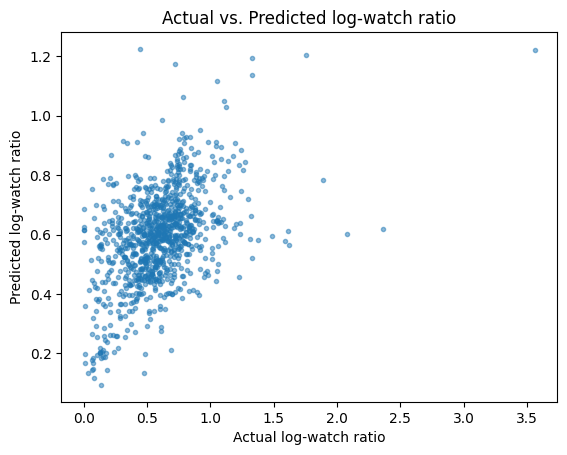

In [8]:
# Assignment 08-23: watch prediction (pipeline + ONE HOT ENCODING + scaling)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

DATA_DIR = "./KuaiRec 2.0/data/"

def get_kuairec_data(data_dir=DATA_DIR):
    try:
        small_matrix   = pd.read_csv(os.path.join(data_dir, "small_matrix.csv"))
        user_features  = pd.read_csv(os.path.join(data_dir, "user_features.csv"))
        item_daily_feat = pd.read_csv(os.path.join(data_dir, "item_daily_features.csv"))
    except FileNotFoundError as e:
        print("Data file not found at", data_dir)
        raise
    return small_matrix, item_daily_feat, user_features

def extract_features_labels(small_matrix, item_daily_feat, user_features):
    # Join user + item features
    merged_user_matrix = small_matrix.merge(user_features, how='left', on='user_id')
    merged_matrix = merged_user_matrix.merge(item_daily_feat, how='left', on=['video_id', 'date'])

    # Clean & subsample
    merged_matrix = merged_matrix.dropna()
    subsampled_matrix = merged_matrix.sample(n=10000, random_state=0)

    # TARGET + FEATURES PICKED 
    label_name = 'watch_ratio'  # target
    # numeric features (kept as numeric)
    numeric_cols = ['like_cnt', 'comment_cnt', 'follow_user_num_x', 'friend_user_num']
    # categorical features (must one-hot encode)
    categorical_cols = ['music_id']

    y = np.log1p(subsampled_matrix[label_name].to_numpy())       # log1p target (same idea as before)
    X = subsampled_matrix[numeric_cols + categorical_cols].copy() # DataFrame of features

    return y, X, numeric_cols, categorical_cols

# LOAD & PREP 
small_matrix, item_daily_feat, user_features = get_kuairec_data()
y_all, X_all, numeric_cols, categorical_cols = extract_features_labels(
    small_matrix, item_daily_feat, user_features
)

# first 9000 train, rest eval
X_train, y_train = X_all.iloc[:9000], y_all[:9000]
X_eval,  y_eval  = X_all.iloc[9000:], y_all[9000:]

#  PIPELINE 
# numeric: log1p to tame heavy tails, then standardize
numeric_tf = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# Categorical: one-hot (ignore unseen categories at eval time)
categorical_tf = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols),
    ],
    remainder='drop'
)

# full pipeline = preprocessing + model
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Ridge())
])

# TUNE & FIT 
param_grid = {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
search = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
search.fit(X_train, y_train)

best_alpha = search.best_params_['model__alpha']
print(f'Best alpha: {best_alpha}')

best_model = search.best_estimator_

# Train MSE (on transformed features inside pipeline)
from sklearn.metrics import mean_squared_error
train_pred = best_model.predict(X_train)
eval_pred  = best_model.predict(X_eval)

print('Training loss:', mean_squared_error(y_train, train_pred))
print('Testing loss:',  mean_squared_error(y_eval,  eval_pred))

# PLOT 
plt.plot(y_eval, eval_pred, '.', alpha=0.5)
plt.xlabel('Actual log-watch ratio')
plt.ylabel('Predicted log-watch ratio')
plt.title('Actual vs. Predicted log-watch ratio')
plt.show()


Best alpha: 10.0
Training loss: 0.031097178796911484
Testing loss: 0.028272531287081567


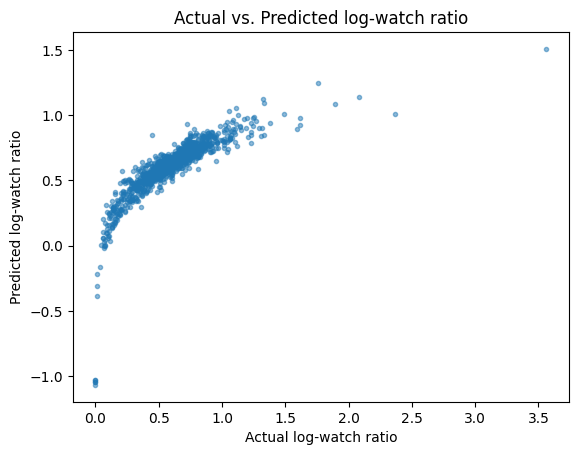

In [13]:
# Assignment 08-23: watch prediction (pipeline + More Numerical Features ONE HOT ENCODING + scaling)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error  # <-- added import

DATA_DIR = "./KuaiRec 2.0/data/"

def get_kuairec_data(data_dir=DATA_DIR):
    try:
        small_matrix    = pd.read_csv(os.path.join(data_dir, "small_matrix.csv"))
        user_features   = pd.read_csv(os.path.join(data_dir, "user_features.csv"))
        item_daily_feat = pd.read_csv(os.path.join(data_dir, "item_daily_features.csv"))
    except FileNotFoundError as e:
        print("Data file not found at", data_dir)
        raise
    return small_matrix, item_daily_feat, user_features  

def extract_features_labels(small_matrix, item_daily_feat, user_features):
    # Join user + item features
    merged_user_matrix = small_matrix.merge(user_features, how='left', on='user_id')
    merged_matrix = merged_user_matrix.merge(item_daily_feat, how='left', on=['video_id', 'date'])

    # Clean & subsample
    merged_matrix = merged_matrix.dropna()
    subsampled_matrix = merged_matrix.sample(n=10000, random_state=0)

    #TARGET + FEATURES 
    label_name = 'watch_ratio'  # target

    
    # NUMERIC FEATURES (expanded, but only keep those that exist)
    # (We include both *_x and *_y in case of name clashes from the merge)
    candidate_numeric = [
        # from item_daily_features (and possible _y suffix)
        'like_cnt', 'comment_cnt', 'share_cnt', 'play_cnt',
        'complete_play_cnt', 'valid_play_cnt',
        'play_duration_y', 'video_duration_y', 'play_user_num',
        'like_user_num', 'share_user_num', 'comment_user_num',
        'long_time_play_cnt', 'short_time_play_cnt',
        'follow_cnt', 'cancel_follow_cnt',
        'click_like_cnt', 'double_click_cnt', 'cancel_like_cnt',
        'comment_like_cnt', 'direct_comment_cnt', 'reply_comment_cnt',
        'play_progress', 'comment_stay_duration',
        'show_cnt', 'collect_cnt', 'cancel_collect_cnt',
        'download_cnt', 'reduce_similar_cnt',

        # from small_matrix (and possible _x suffix)
        'play_duration_x', 'video_duration_x',

        # from user_features (note: follow_user_num_x due to merge)
        'follow_user_num_x', 'fans_user_num', 'friend_user_num',
    ]

    # add a couple derived numerics
    if {'like_cnt', 'comment_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['like_rate'] = subsampled_matrix['like_cnt'] / (
            subsampled_matrix['like_cnt'] + subsampled_matrix['comment_cnt'] + 1.0
        )
        candidate_numeric.append('like_rate')

    if {'like_cnt', 'comment_cnt', 'share_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['engage_cnt'] = (
            subsampled_matrix['like_cnt'] +
            subsampled_matrix['comment_cnt'] +
            subsampled_matrix['share_cnt']
        )
        candidate_numeric.append('engage_cnt')

    # keep only columns that actually exist after your merge
    numeric_cols = [c for c in candidate_numeric if c in subsampled_matrix.columns]


    # categorical features (unchanged: only music_id)
    categorical_cols = ['music_id']

    y = np.log1p(subsampled_matrix[label_name].to_numpy())       # log1p target
    X = subsampled_matrix[numeric_cols + categorical_cols].copy()  # features

    return y, X, numeric_cols, categorical_cols

# LOAD & PREP 
small_matrix, item_daily_feat, user_features = get_kuairec_data()
y_all, X_all, numeric_cols, categorical_cols = extract_features_labels(
    small_matrix, item_daily_feat, user_features
)

# first 9000 train, rest eval
X_train, y_train = X_all.iloc[:9000], y_all[:9000]
X_eval,  y_eval  = X_all.iloc[9000:], y_all[9000:]

# PIPELINE 
# numeric: log1p to tame heavy tails, then standardize
numeric_tf = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# Categorical: one-hot (ignore unseen categories at eval time)
# (unchanged)
categorical_tf = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


#column transformer on numeric_tf, categorical_tf

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols),
    ],
    remainder='drop'
)

# full pipeline = preprocessing + model
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Ridge())
])

#  TUNE & FIT 
param_grid = {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
search = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
search.fit(X_train, y_train)

best_alpha = search.best_params_['model__alpha']
print(f'Best alpha: {best_alpha}')

best_model = search.best_estimator_

# Train/Eval MSE 
train_pred = best_model.predict(X_train)
eval_pred  = best_model.predict(X_eval)

print('Training loss:', mean_squared_error(y_train, train_pred))
print('Testing loss:',  mean_squared_error(y_eval,  eval_pred))


plt.plot(y_eval, eval_pred, '.', alpha=0.5)
plt.xlabel('Actual log-watch ratio')
plt.ylabel('Predicted log-watch ratio')
plt.title('Actual vs. Predicted log-watch ratio')
plt.show()


Best alpha: 11
Training loss: 0.03129388088445245
Testing loss: 0.0282928956052298


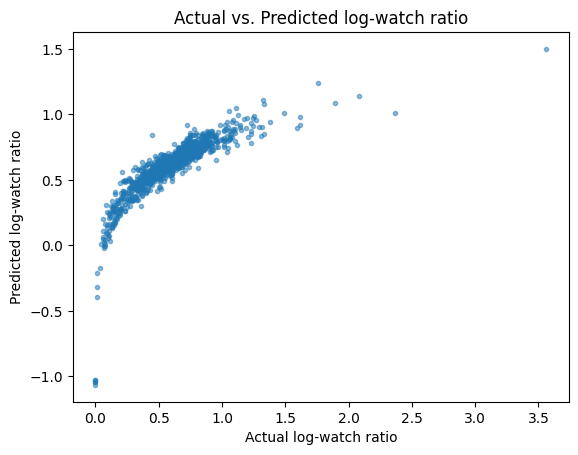

In [15]:
# Assignment 08-23: watch prediction (pipeline + More Numerical Features ONE HOT ENCODING + scaling)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error  # <-- added import

DATA_DIR = "./KuaiRec 2.0/data/"

def get_kuairec_data(data_dir=DATA_DIR):
    try:
        small_matrix    = pd.read_csv(os.path.join(data_dir, "small_matrix.csv"))
        user_features   = pd.read_csv(os.path.join(data_dir, "user_features.csv"))
        item_daily_feat = pd.read_csv(os.path.join(data_dir, "item_daily_features.csv"))
    except FileNotFoundError as e:
        print("Data file not found at", data_dir)
        raise
    return small_matrix, item_daily_feat, user_features  

def extract_features_labels(small_matrix, item_daily_feat, user_features):
    # Join user + item features
    merged_user_matrix = small_matrix.merge(user_features, how='left', on='user_id')
    merged_matrix = merged_user_matrix.merge(item_daily_feat, how='left', on=['video_id', 'date'])

    # Clean & subsample
    merged_matrix = merged_matrix.dropna()
    subsampled_matrix = merged_matrix.sample(n=10000, random_state=0)

    #TARGET + FEATURES 
    label_name = 'watch_ratio'  # target

    
    # NUMERIC FEATURES (expanded, but only keep those that exist)
    # (We include both *_x and *_y in case of name clashes from the merge)
    candidate_numeric = [
        # from item_daily_features (and possible _y suffix)
        'like_cnt', 'comment_cnt', 'share_cnt', 'play_cnt',
        'complete_play_cnt', 'valid_play_cnt',
        'play_duration_y', 'video_duration_y', 'play_user_num',
        'like_user_num', 'share_user_num', 'comment_user_num',
        'long_time_play_cnt', 'short_time_play_cnt',
        'follow_cnt', 'cancel_follow_cnt',
        'click_like_cnt', 'double_click_cnt', 'cancel_like_cnt',
        'comment_like_cnt', 'direct_comment_cnt', 'reply_comment_cnt',
        'play_progress', 'comment_stay_duration',
        'show_cnt', 'collect_cnt', 'cancel_collect_cnt',
        'download_cnt', 'reduce_similar_cnt',

        # from small_matrix (and possible _x suffix)
        'play_duration_x', 'video_duration_x',

        # from user_features (note: follow_user_num_x due to merge)
        'follow_user_num_x', 'fans_user_num', 'friend_user_num',
    ]
    # add a couple derived numerics
    if {'like_cnt', 'comment_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['like_rate'] = subsampled_matrix['like_cnt'] / (
            subsampled_matrix['like_cnt'] + subsampled_matrix['comment_cnt'] + 1.0
        )
        candidate_numeric.append('like_rate')

    if {'like_cnt', 'comment_cnt', 'share_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['engage_cnt'] = (
            subsampled_matrix['like_cnt'] +
            subsampled_matrix['comment_cnt'] +
            subsampled_matrix['share_cnt']
        )
        candidate_numeric.append('engage_cnt')

    # keep only columns that actually exist after your merge
    numeric_cols = [c for c in candidate_numeric if c in subsampled_matrix.columns]


    # categorical features (unchanged: only music_id)
    categorical_cols = ['music_id']

    y = np.log1p(subsampled_matrix[label_name].to_numpy())       # log1p target
    X = subsampled_matrix[numeric_cols + categorical_cols].copy()  # features

    return y, X, numeric_cols, categorical_cols


# LOAD & PREP 
small_matrix, item_daily_feat, user_features = get_kuairec_data()
y_all, X_all, numeric_cols, categorical_cols = extract_features_labels(
    small_matrix, item_daily_feat, user_features
)

# first 9000 train, rest eval
X_train, y_train = X_all.iloc[:9000], y_all[:9000]
X_eval,  y_eval  = X_all.iloc[9000:], y_all[9000:]

# PIPELINE 
# numeric: log1p to tame heavy tails, then standardize
numeric_tf = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# Categorical: one-hot (ignore unseen categories at eval time)
# (unchanged)
categorical_tf = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


#column transformer on numeric_tf, categorical_tf

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols),
    ],
    remainder='drop'
)

# full pipeline = preprocessing + model
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Ridge())
])

#  TUNE & FIT 
param_grid = {'model__alpha': [8.0,9.0,10.0,10.1,10.2,10.3,10.4,11]}
search = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
search.fit(X_train, y_train)

best_alpha = search.best_params_['model__alpha']
print(f'Best alpha: {best_alpha}')

best_model = search.best_estimator_

# Train/Eval MSE 
train_pred = best_model.predict(X_train)
eval_pred  = best_model.predict(X_eval)

print('Training loss:', mean_squared_error(y_train, train_pred))
print('Testing loss:',  mean_squared_error(y_eval,  eval_pred))


plt.plot(y_eval, eval_pred, '.', alpha=0.5)
plt.xlabel('Actual log-watch ratio')
plt.ylabel('Predicted log-watch ratio')
plt.title('Actual vs. Predicted log-watch ratio')
plt.show()


Best alpha: 11.0
Training loss: 0.031411055645040736
Testing loss: 0.03243527651542667


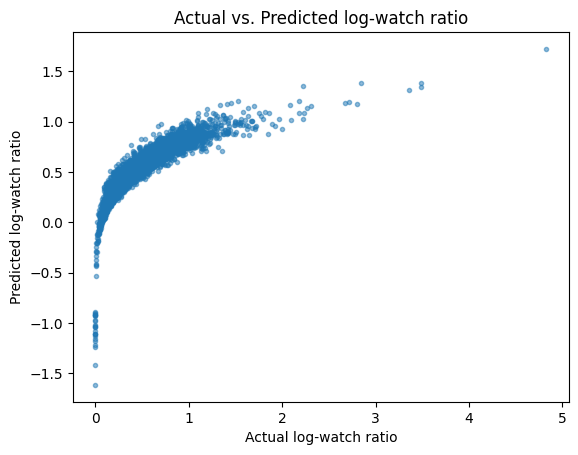

In [16]:
# Assignment 08-23: watch prediction (pipeline + More Numerical Features ONE HOT ENCODING + scaling)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error  # <-- added import

DATA_DIR = "./KuaiRec 2.0/data/"

def get_kuairec_data(data_dir=DATA_DIR):
    try:
        small_matrix    = pd.read_csv(os.path.join(data_dir, "small_matrix.csv"))
        user_features   = pd.read_csv(os.path.join(data_dir, "user_features.csv"))
        item_daily_feat = pd.read_csv(os.path.join(data_dir, "item_daily_features.csv"))
    except FileNotFoundError as e:
        print("Data file not found at", data_dir)
        raise
    return small_matrix, item_daily_feat, user_features  

def extract_features_labels(small_matrix, item_daily_feat, user_features):
    # Join user + item features
    merged_user_matrix = small_matrix.merge(user_features, how='left', on='user_id')
    merged_matrix = merged_user_matrix.merge(item_daily_feat, how='left', on=['video_id', 'date'])

    # Clean & subsample
    merged_matrix = merged_matrix.dropna()
    subsampled_matrix = merged_matrix.sample(n=30000, random_state=0)

    #TARGET + FEATURES 
    label_name = 'watch_ratio'  # target
     # NUMERIC FEATURES (expanded, but only keep those that exist)
    # (We include both *_x and *_y in case of name clashes from the merge)
    candidate_numeric = [
        # from item_daily_features (and possible _y suffix)
        'like_cnt', 'comment_cnt', 'share_cnt', 'play_cnt',
        'complete_play_cnt', 'valid_play_cnt',
        'play_duration_y', 'video_duration_y', 'play_user_num',
        'like_user_num', 'share_user_num', 'comment_user_num',
        'long_time_play_cnt', 'short_time_play_cnt',
        'follow_cnt', 'cancel_follow_cnt',
        'click_like_cnt', 'double_click_cnt', 'cancel_like_cnt',
        'comment_like_cnt', 'direct_comment_cnt', 'reply_comment_cnt',
        'play_progress', 'comment_stay_duration',
        'show_cnt', 'collect_cnt', 'cancel_collect_cnt',
        'download_cnt', 'reduce_similar_cnt',

        # from small_matrix (and possible _x suffix)
        'play_duration_x', 'video_duration_x',

        # from user_features (note: follow_user_num_x due to merge)
        'follow_user_num_x', 'fans_user_num', 'friend_user_num',
    ]
    # add a couple derived numerics
    if {'like_cnt', 'comment_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['like_rate'] = subsampled_matrix['like_cnt'] / (
            subsampled_matrix['like_cnt'] + subsampled_matrix['comment_cnt'] + 1.0
        )
        candidate_numeric.append('like_rate')

    if {'like_cnt', 'comment_cnt', 'share_cnt'}.issubset(subsampled_matrix.columns):
        subsampled_matrix['engage_cnt'] = (
            subsampled_matrix['like_cnt'] +
            subsampled_matrix['comment_cnt'] +
            subsampled_matrix['share_cnt']
        )
        candidate_numeric.append('engage_cnt')
        # keep only columns that actually exist after your merge
    numeric_cols = [c for c in candidate_numeric if c in subsampled_matrix.columns]


    # categorical features (unchanged: only music_id)
    categorical_cols = ['music_id']

    y = np.log1p(subsampled_matrix[label_name].to_numpy())       # log1p target
    X = subsampled_matrix[numeric_cols + categorical_cols].copy()  # features

    return y, X, numeric_cols, categorical_cols


# LOAD & PREP 
small_matrix, item_daily_feat, user_features = get_kuairec_data()
y_all, X_all, numeric_cols, categorical_cols = extract_features_labels(
    small_matrix, item_daily_feat, user_features
)

# first 9000 train, rest eval
X_train, y_train = X_all.iloc[:25000], y_all[:25000]
X_eval,  y_eval  = X_all.iloc[25000:], y_all[25000:]

# PIPELINE 
# numeric: log1p to tame heavy tails, then standardize
numeric_tf = Pipeline(steps=[
    ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

# Categorical: one-hot (ignore unseen categories at eval time)
# (unchanged)
categorical_tf = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, numeric_cols),
        ('cat', categorical_tf, categorical_cols),
    ],
    remainder='drop'
)


#column transformer on numeric_tf, categorical_tf

# full pipeline = preprocessing + model
pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', Ridge())
])

#  TUNE & FIT 
param_grid = {'model__alpha': [0.01, 0.1, 1.0,5.0, 10.0,10.5,11.0]}
search = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
search.fit(X_train, y_train)

best_alpha = search.best_params_['model__alpha']
print(f'Best alpha: {best_alpha}')

best_model = search.best_estimator_

# Train/Eval MSE 
train_pred = best_model.predict(X_train)
eval_pred  = best_model.predict(X_eval)

print('Training loss:', mean_squared_error(y_train, train_pred))
print('Testing loss:',  mean_squared_error(y_eval,  eval_pred))


plt.plot(y_eval, eval_pred, '.', alpha=0.5)
plt.xlabel('Actual log-watch ratio')
plt.ylabel('Predicted log-watch ratio')
plt.title('Actual vs. Predicted log-watch ratio')
plt.show()
